<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/multi-label/CEL/MultiLabel_CEL_inception_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Multilabel

https://walkwithfastai.com/Multi_Label

## Librerías

Instalamos la última versión de Fastai:

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 214 kB 7.3 MB/s 
     |████████████████████████████████| 61 kB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 7.3 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
!pip install wwf -q

Importamos las librerías necesarias:

In [2]:
from fastai.vision.all import *

#Estas liberías son para las arquitectuas EffiecientNet e Inception
import timm
from wwf.utils import *
from wwf.vision.timm import *

In [3]:
import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

## Dataset

Descargamos el dataset

In [4]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-07-01 15:14:49 URL:https://ucb80d04e6f862d79f1fe1ff842f.dl.dropboxusercontent.com/cd/0/inline2/BoTlCcpvQF2s5iLY0IidjD7ORFV0AOHP1to_YQchvYARETdiSsb7obtSMcL-ZM46vbWhyvS0JhHilxrhSlZ6eqw37TJSmDyDxNyecjh_8Iei__2QKPV7QWALDq1228UtBLELbXAc1-yLCRbgCDEXE3sEkuy2kZMd4fAf5VwtJIy-V3yfeCLS1FsIECaWjjwM23U84yBPUGTarS3ol64S33M4Uc7U1SZI5VW2BiMiI_GmRmsbJd0aYmUZ3j3zWSG4AwgQUUnvCGIT-PI9p7UZCA2gg3IaAorSFAB-wGJoP-zMsxbkCVTlSiPEt3oS-YlV4_O021DnRyPWW3LOA5THNVBhreptgPpRR_GEmzmtszGYU-_eahU_wAnzPt-9J4_hYIlc2exWc9T1ixaybjQFpWDv82_9TFGOZAsFQaco5TyoGA/file [138777773/138777773] -> "train.zip" [1]
2022-07-01 15:14:50 URL:https://uc83c5d680daadb584209647dc7e.dl.dropboxusercontent.com/cd/0/inline2/BoSGC215u8BcCIC11J5xy305xcpr7D3g6rzGz4FdUt-_mMd_lbZBisDM844EQj3WqVsLwbl8x3ju37bHsE0HgWIeqV4yg4zbmP-w_3n01EZTpJwoUgO1fRTYrLCOHCho0-7iv-zOoO6Y_xiw-kLF3D5EqK24tEAeTl6B48VUcHQxwX6uPUWl8FMAgtL4QeQdEg5XxqKTkWrZ5ubXBfHcnXPUj9SbMLTIfSA3e_6nfQ_YgiQ7TUMRE3TnozNOsG3EDZbv0NctNx0KHjRE65GAvDmLXavRnPi60_cyvxgepiDpvAGEepga7ka08KTGBf8IBWO

In [5]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [6]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [7]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [8]:
df_train

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
def crearDataFrame(df, nombreConjunto):
  columnas = list(df.columns)[2:]

  nombres = [] #nombre de las imagenes
  enfermedades = [] #nombres de las enfermedades

  for i in df.index:
    cadena = ''
    nombres.append(nombreConjunto + str(df['ID'][i]))
    if df['Disease_Risk'][i] == 1:
      for x in columnas:
        if(df[x][i]==1):
          cadena += ' ' + x
    else:
      cadena = ' NORMAL'
    enfermedades.append(cadena[1:])
  data = {'nombre_img': nombres,
        'tags': enfermedades
        }
  return pd.DataFrame(data)

In [10]:
df_train_ML = crearDataFrame(df_train, str(trainPath) + '/Training/')
df_test_ML = crearDataFrame(df_test, str(testPath) + '/Test/')
df_val_ML = crearDataFrame(df_val, str(valPath) + '/Validation/')

In [11]:
df_train_ML.head(10)

,nombre_img,tags
0,Training_Set_Pre/Training/1,DR
1,Training_Set_Pre/Training/2,DR
2,Training_Set_Pre/Training/3,DR
3,Training_Set_Pre/Training/4,MH ODC
4,Training_Set_Pre/Training/5,DR LS
5,Training_Set_Pre/Training/6,ARMD MYA
6,Training_Set_Pre/Training/7,ARMD MYA
7,Training_Set_Pre/Training/8,ARMD MYA
8,Training_Set_Pre/Training/9,ERM
9,Training_Set_Pre/Training/10,NORMAL


In [12]:
df_train_ML['is_valid'] = False
df_val_ML['is_valid'] = True

In [13]:
df_train_val = pd.concat([df_train_ML, df_val_ML])

In [14]:
df_train_val

,nombre_img,tags,is_valid
0,Training_Set_Pre/Training/1,DR,False
1,Training_Set_Pre/Training/2,DR,False
2,Training_Set_Pre/Training/3,DR,False
3,Training_Set_Pre/Training/4,MH ODC,False
4,Training_Set_Pre/Training/5,DR LS,False
...,...,...,...
635,Evaluation_Set_Pre/Validation/636,TSLN,True
636,Evaluation_Set_Pre/Validation/637,TSLN,True
637,Evaluation_Set_Pre/Validation/638,NORMAL,True
638,Evaluation_Set_Pre/Validation/639,NORMAL,True


In [15]:
# df_train_val[df_train_val['nombre_img']=='val/640']['is_valid'].values[0]

In [16]:
def conjuntoImg(nombreImg):
  return True if df[df['nombre_img'] == nombreImg[0]]['is_valid'].values[0] else False

In [17]:
df = df_train_val

In [18]:
conjuntoImg(['Training_Set_Pre/Training/503','ODP', True])

False

## Datablock

In [19]:
# batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [20]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  get_x=ColReader(0, suff='.png'),
                  splitter=FuncSplitter(conjuntoImg),
                  get_y=ColReader(1, label_delim=' '),
                  item_tfms = Resize(256),
                  batch_tfms = aug_transforms(size=128,min_scale=0.75))

In [21]:
dls = db.dataloaders(df.values)

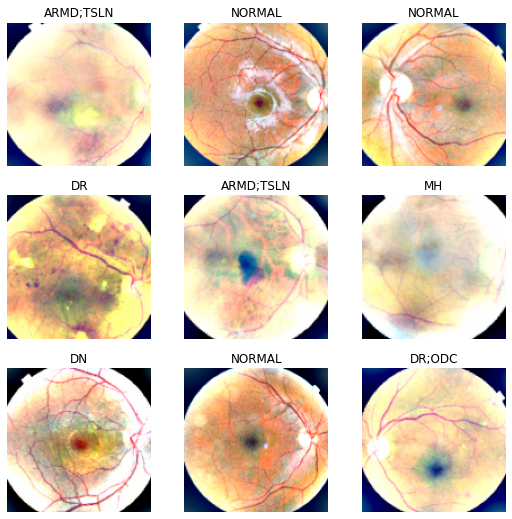

In [22]:
dls.show_batch()

## Entrenar Modelo

In [ ]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()
]

In [ ]:
metrics = [ accuracy_multi, PrecisionMulti(), RecallMulti(), F1ScoreMulti() ]
learn = timm_learner(dls, "inception_v4", pretrained=True, metrics=metrics, cbs=callbacks).to_fp16()

SuggestedLRs(minimum=0.02089296132326126, steep=0.03981071710586548)

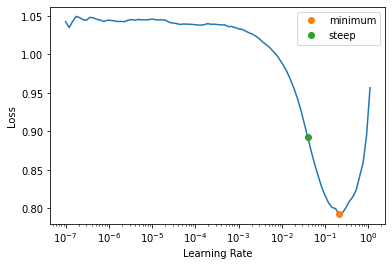

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep))

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,0.563779,0.218852,0.952425,0.096239,0.030150,0.034895,00:12


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.21885228157043457.


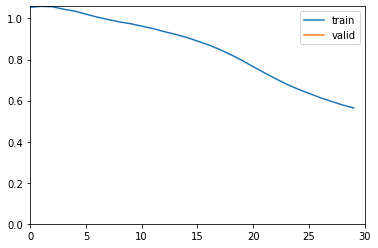

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,0.183039,0.147009,0.957866,0.136878,0.025183,0.034286,00:13
1,0.168661,0.138946,0.958190,0.192374,0.023305,0.034602,00:13
2,0.157202,0.141721,0.958351,0.157896,0.037886,0.043762,00:14
3,0.148052,0.135380,0.958297,0.126160,0.045995,0.056738,00:14
4,0.140854,0.127991,0.959591,0.173248,0.071852,0.093627,00:13
5,0.134923,0.128250,0.959483,0.169343,0.065955,0.084863,00:14
6,0.129006,0.124312,0.961907,0.201237,0.098875,0.120332,00:14
7,0.123520,0.123087,0.961584,0.216909,0.086894,0.105561,00:14
8,0.118682,0.126334,0.963147,0.267954,0.111365,0.139243,00:13
9,0.113677,0.121319,0.962608,0.307004,0.113901,0.145304,00:14


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.14700928330421448.


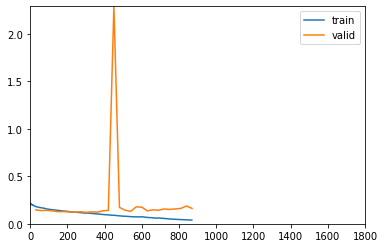

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with valid_loss value: 0.13894610106945038.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 3 with valid_loss value: 0.13538016378879547.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 4 with valid_loss value: 0.12799109518527985.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 6 with valid_loss value: 0.1243121474981308.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 7 with valid_loss value: 0.12308702617883682.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 9 with valid_loss value: 0.12131911516189575.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

No improvement since epoch 9: early stopping


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 5min 18s, sys: 14.8 s, total: 5min 32s
Wall time: 7min 25s


In [ ]:
%%time
learn.fine_tune(60,base_lr=3e-2)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


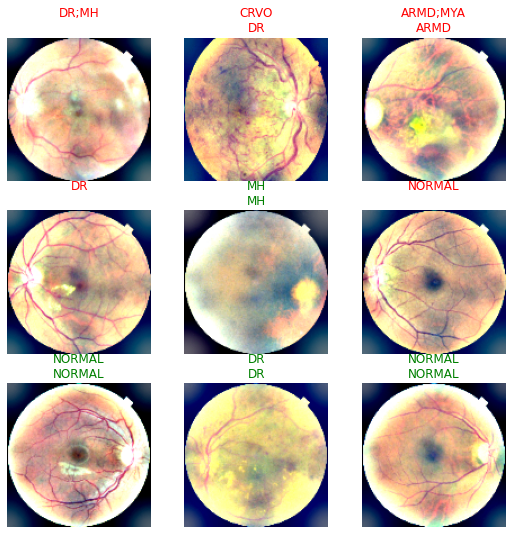

In [ ]:
learn.show_results()

## Evaluar el modelo

In [ ]:
dbTest = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, suff='.png'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms = Resize(256),
                   batch_tfms = aug_transforms(size=128,min_scale=0.75))

In [ ]:
dlsTest = dbTest.dataloaders(df_test_ML)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Better model found at epoch 0 with valid_loss value: 0.9461206793785095.


(#5) [0.17709240317344666,0.9461206793785095,0.043286867204695524,0.035402298850574714,0.018219356708200518]

Exportamos el modelo

In [ ]:
learn.to_fp32()
learn.export('MultiLabel_CEL_inception_v4.pkl')

## Matriz de confusión

In [23]:
learn_inf = load_learner('MultiLabel_CEL_inception_v4.pkl')
learnInterp = timm_learner(dls, 'inception_v3').to_fp16()
learnInterp.model = learn_inf.model

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [24]:
y_true = []
y_pred = []
col = list(df_test.columns[1:])
col[0] = 'NORMAL'

for i in df_test.index:
  pred = list(learnInterp.predict('Test_Set_Pre/Test/' + str(df_test['ID'][i])+ '.png')[0])

  #Creamos el array con las predicciones en el orden correcto
  zeros = [0]*29
  for p in pred:
    zeros[col.index(p)] = 1
  y_pred.append(zeros)

  #Obtener los valores reales, si el riesgo de enfermedad es 1 se deja a 0 y sino a 1(será la clase normal)
  #ya que la primera columna es para la clase normal en nuestra logica
  real = list(df_test.iloc[i].values)[1:]
  #No pertenece a la clase normal, se deja a 0
  if(real[0] == 1):
    real[0] = 0
  #Quiere decir que pertenece a la clase normal, por lo que lo dejamos a uno
  else:
    real[0] = 1
  y_true.append(real)

In [25]:
from sklearn.metrics import multilabel_confusion_matrix

vis_arr = multilabel_confusion_matrix(np.array(y_true), np.array(y_pred))

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

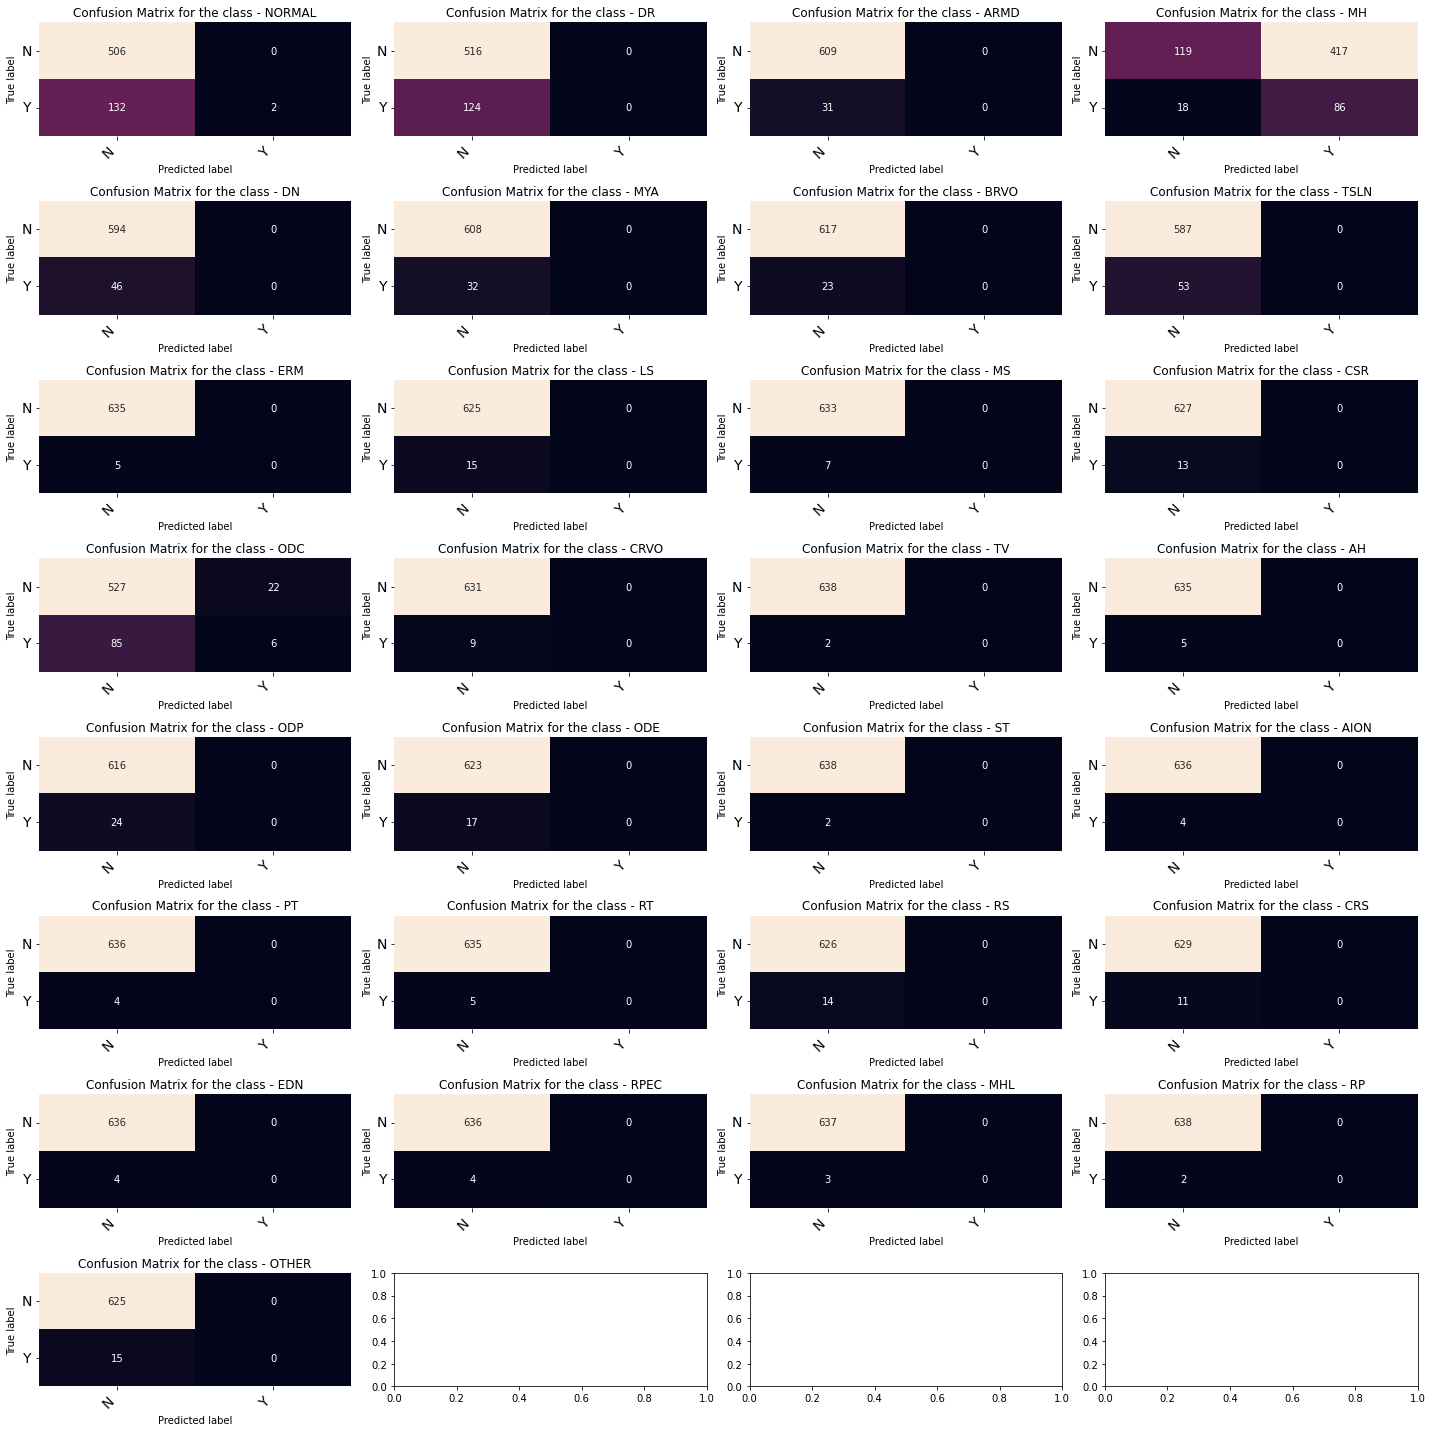

In [27]:
fig, ax = plt.subplots(8, 4, figsize=(20, 20))

for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, col):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

## Comprobaciones manuales

In [ ]:
learn_inf = load_learner('MultiLabel_CEL_inception_v4.pkl')

In [ ]:
df_test[df_test['Disease_Risk']==1] #enfermedad

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,636,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
636,637,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
637,638,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
638,639,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
df_test[df_test['Disease_Risk']==0] #sanas
# df_test.iloc[0:20,:]

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
244,245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271,272,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272,273,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,276,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276,277,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,623,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
625,626,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
626,627,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
627,628,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Imágenes con enfermedad**

In [ ]:
learn_inf.predict('Test_Set_Pre/Test/1.png')[0] #DR, TLSN

(#1) ['MH']

In [ ]:
learn_inf.predict('Test_Set_Pre/Test/2.png')[0] #DR, BRVO

(#1) ['MH']

In [ ]:
learn_inf.predict('Test_Set_Pre/Test/3.png')[0] #DR, ODC

(#0) []

In [ ]:
learn_inf.predict('Test_Set_Pre/Test/10.png')[0] #DR, LS, ODC

(#1) ['MH']

**Imágenes normales:**

In [ ]:
learn_inf.predict('Test_Set_Pre/Test/272.png')[0]

(#1) ['MH']

In [ ]:
learn_inf.predict('Test_Set_Pre/Test/623.png')[0]

(#1) ['MH']

In [ ]:
learn_inf.predict('Test_Set_Pre/Test/626.png')[0]

(#0) []

In [ ]:
learn_inf.predict('Test_Set_Pre/Test/628.png')[0]

(#0) []

In [ ]:
learn_inf.predict('Test_Set_Pre/Test/629.png')[0]

(#1) ['MH']